# Particle Hopping Test - April 7th 2022

Some code to try implementing forward flux for a very simple test system

## Setup

### Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

### Potential

We're going to use a simple quartic potential to emulate a barrier in MD

In [2]:
@vectorize([float32(float32)])
def pot(x):
    x2 = x*x
    return max(2*x2 - x2*x2, 0.0)

SQRT2 = np.sqrt(2.0)

@vectorize([float32(float32)])
def force(x):
    x2 = x*x
    if np.abs(x) < SQRT2:
        return -4*x + 4*x*x2
    else:
        return 0.0

@njit
def force_0(x):
    x2 = x*x
    if np.abs(x) < SQRT2:
        return -4*x + 4*x*x2
    else:
        return 0.0

In [3]:
x = np.linspace(-2, 2, 100, dtype=np.float32)
y = pot(x)
f = force(x)

Text(0.5, 0, '$x$')

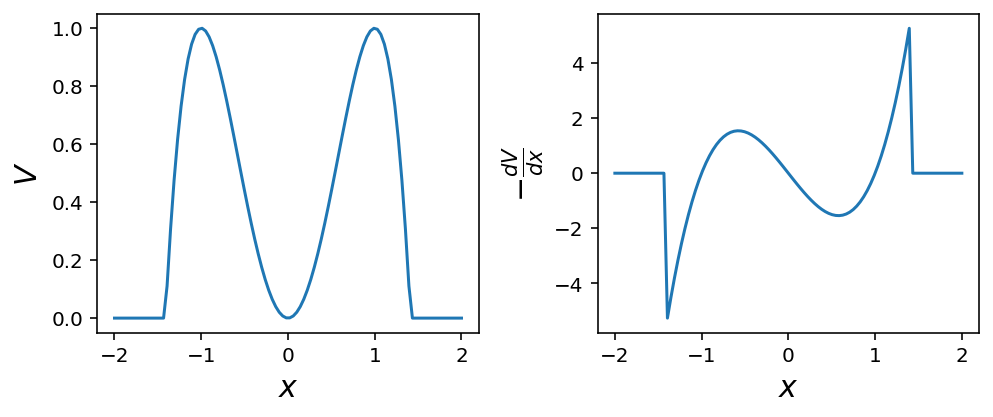

In [4]:
fig, axs = plt.subplots(1,2, figsize=(7, 3), tight_layout=True)

plt.sca(axs[0])
plt.plot(x, y)
plt.ylabel(r"$V$", size=15)
plt.xlabel(r"$x$", size=15)

plt.sca(axs[1])
plt.plot(x, f)
plt.ylabel(r"$-\frac{dV}{dx}$", size=15)
plt.xlabel(r"$x$", size=15)

### Order Parameter

Our code is going to call upon an order parameter function to determine how far
along the simulation state is

In [5]:
@njit
def op(x: float):
    return abs(x)

In [6]:
op(-1.0)

1.0

## Simulation

### Class definition

In [95]:
# @njit
# def _lv_step(xi, vi, ws, m, kT, visc):
#     x = xi
#     v = vi
#     for i in range(len(ws)):



class FFTestSim:

    MAX_W_N = 1_000
    QUANT = 0.99

    MAX_STEPS = 100_000_000

    def __init__(
        self, 
        kT: float, 
        rng: np.random.Generator, 
        op: Callable[[float], float],
        force: Callable[[float], float],
        threshold: Optional[float] = None,
        dt: float = 1e-2,
        m: float = 1.0,
        visc: float = 1.0
    ):
        self.x = np.float32(0.0)
        self.kT = np.float32(kT)
        self.rng = rng
        self.op = op
        self.force = force
        if threshold is not None:
            self.threshold = np.float32(threshold)
        else:
            self.threshold = threshold
        self.dt = np.float32(dt)
        self.sqrt_dt = np.sqrt(self.dt)
        self.m = np.float32(m)
        self.visc = np.float32(visc)
        self.v = np.float32(0.0)
        self.out_x = []
        self.out_v = []
        self.out_op = []
        self._basin = None

    def _n_wiener(self, n: int) -> np.ndarray:
        return self.rng.normal(scale=self.sqrt_dt*self.kT, size=n)

    def _langevin_steps(self, ws: np.ndarray, dump=True):
        for w in ws:
            self.v += (-self.visc*self.v*self.dt + self.force(self.x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
            self.x += self.v*self.dt
            if dump:
                self.out_x.append(self.x)
                self.out_v.append(self.v)
                op_res = self.op(self.x)
                self.out_op.append(op_res)

    def reset(self):
        self.x = np.float32(0.0)
        self.v = np.float32(0.0)

    def reset_out(self):
        self.out_x = []
        self.out_v = []
        self.out_op = []

    def run(self, steps: int):
        ws = self._n_wiener(steps)
        self._langevin_steps(ws)

    def _bootstrap_ff(self, ws: np.ndarray):
        ff_states = []
        last_op_res = 0.0
        for w in ws:
            self.v += (-self.visc*self.v*self.dt + self.force(self.x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
            self.x += self.v*self.dt
            op_res = self.op(self.x)
            if op_res > self.basin and last_op_res < self.basin:
                ff_states.append((self.x, self.v))
            last_op_res = op_res

        return ff_states

    def _run_ff_trails(self, state, trials, barrier):
        # print(state, trials, barrier)
        passed_trials = []
        for trial in range(trials):
            # print("subtrial:", trial)
            self.x = state[0]
            self.v = state[1]
            trial_done = False
            while not trial_done:
                ws = self._n_wiener(self.MAX_W_N)
                for w in ws:
                    self.v += (-self.visc*self.v*self.dt + self.force(self.x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
                    self.x += self.v*self.dt
                    op_res = self.op(self.x)
                    if op_res < self.basin:
                        trial_done = True
                        break
                    elif op_res > barrier:
                        trial_done = True
                        passed_trials.append((self.x, self.v))
                        break
        
        return passed_trials
                    
    
    def run_ff(self, samples: int, trials: int, barrier_step: float, thermalize_steps=1000):
        if self.basin is None:
            raise RuntimeError("'self.basin' was not set")

        self.reset()
        
        # Collecting starting points for trajectory
        ws = self._n_wiener(thermalize_steps)
        self._langevin_steps(ws, dump=False)

        n = 0
        ff_states = []
        while True:
            ws = self._n_wiener(self.MAX_W_N)

            new_states = self._bootstrap_ff(ws)
            ff_states.extend(new_states)

            n += self.MAX_W_N

            if len(ff_states) >= samples:
                ff_states = ff_states[:samples]
                break

            if n > self.MAX_STEPS:
                raise RuntimeError("Max number of simulation steps have been reached")

        # iterate over found samples

        time = n*self.dt
        base_rate = len(ff_states)/time

        fluxes = []
        barriers = np.arange(self.basin, 1.1, barrier_step)
        for idx, state in enumerate(ff_states):
            print("state:", idx)
            barrier = self.basin
            state_flux = []
            last_trial_set = [state]
            prod_accum_trials = 1.0
            while True:
                barrier += barrier_step
                if len(last_trial_set) == 0:
                    state_flux.append(0.0)
                    if barrier > 1.1:  # arbitrary
                        break
                    else:
                        continue
                # print("barrier:", barrier)
                # print("    test_states:", len(last_trial_set))
                all_passed_trials = []
                k_trials = trials//len(last_trial_set)
                for new_state in last_trial_set:
                    passed_trials = self._run_ff_trails(new_state, k_trials, barrier)
                    all_passed_trials.extend(passed_trials)
                    # print("passed trials:", num_passed_trials)
                    # used_trials = trials
                last_trial_set = all_passed_trials
                prod_accum_trials *= float(k_trials)
                state_flux.append(len(all_passed_trials)/(prod_accum_trials))
                
                if barrier > 1.1:  # arbitrary
                    break
            fluxes.append(state_flux)
            
        return base_rate, fluxes, barriers, ff_states

    @property
    def basin(self):
        return self._basin

    @basin.setter
    def basin(self, value: float):
        self._basin = value

    def sample_basin(self, steps: int, quant: float = 0.99) -> float:

        if quant <= 0.0 or quant >= 1.0:
            raise ValueError("'quant' must be in the range (0.0, 1.0)")

        self.reset()
        self.reset_out()

        thres = self.threshold

        ws = self._n_wiener(steps)
        for w in ws:
            x = self.x
            self.x += self.v*self.dt
            self.v += (-self.visc*self.v*self.dt + self.force(x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
            self.out_x.append(self.x)
            self.out_v.append(self.v)
            op_res = self.op(self.x)
            self.out_op.append(op_res)
            # if thres is not None and op_res >= thres:
    
        return np.quantile(self.out_op, quant)




### Testing

In [89]:
rng = np.random.default_rng()

In [274]:
sim = FFTestSim(0.45, rng, op, lambda x: 0.0, threshold=1.0, dt=0.1)
sim.run(100_000)

In [275]:
from scipy.stats import norm as sp_norm

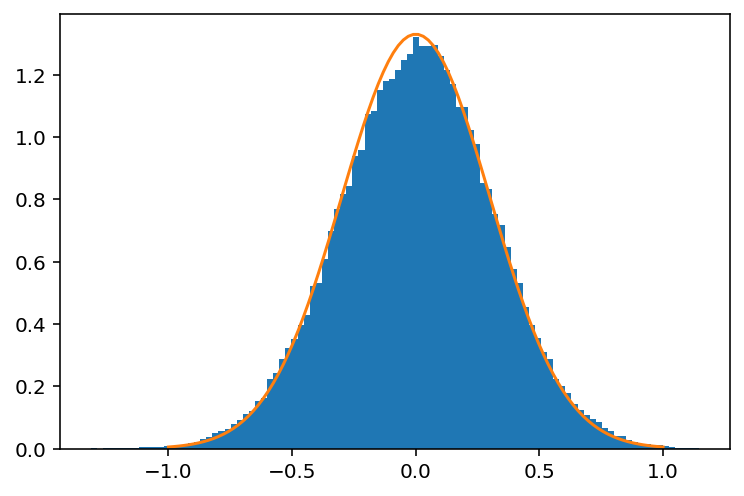

In [276]:
plt.hist(sim.out_v, bins=100, density=True);
x = np.linspace(-1.0, 1.0, 100)
rv = sp_norm(scale=0.3)
plt.plot(x, rv.pdf(x))

In [96]:
sim = FFTestSim(0.40, rng, op, force_0, threshold=1.0, dt=0.1)

In [97]:
sim.basin = sim.sample_basin(100_000, quant=0.995)

In [98]:
sim.x

0.20259299930408442

In [99]:
sim.basin

0.47778651269603745

In [100]:
ff_data = sim.run_ff(10, 1000, 0.05)

state: 0
state: 1
state: 2
state: 3
state: 4
state: 5
state: 6
state: 7
state: 8
state: 9


In [82]:
ff_data[2]

array([0.47848653, 0.52848653, 0.57848653, 0.62848653, 0.67848653,
       0.72848653, 0.77848653, 0.82848653, 0.87848653, 0.92848653,
       0.97848653, 1.02848653, 1.07848653])

In [83]:
ff_data[3]

[(0.49328839426235305, 0.415126639717932),
 (-0.4831441208896843, -0.31990775396510085),
 (-0.49587213137831104, -0.2444422285095966),
 (0.4952669248366526, 0.4376804599342077),
 (-0.4794530078630352, -0.32443455958122636),
 (0.4853194059260192, 0.45449046675202176),
 (0.4947331421873477, 0.7474743447025975),
 (-0.5098191460294159, -0.523621916241152),
 (0.49070025522235244, 0.2731045576471846),
 (0.4983081062705191, 0.44771904161767756)]

In [66]:
idx = 0
pos = [x[0] for x in ff_data[3][idx]]
vel = [x[1] for x in ff_data[3][idx]]

plt.plot(ff_data[2], pos, "x")

plt.plot(ff_data[2], vel, "o")

IndexError: invalid index to scalar variable.

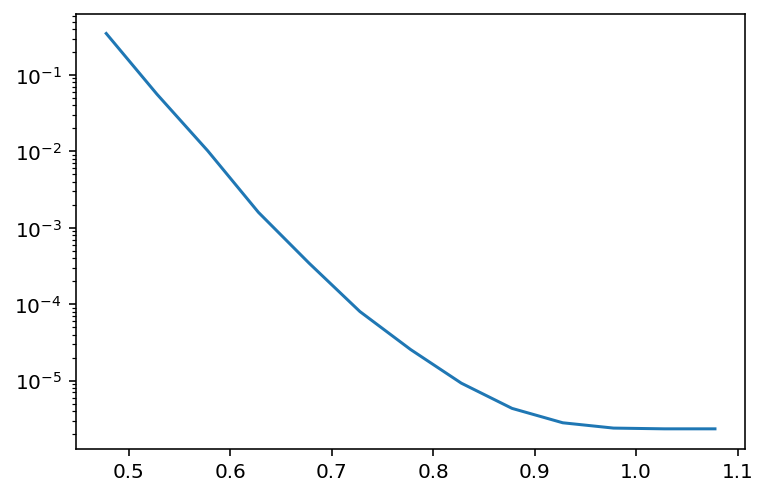

In [101]:
plt.plot(ff_data[2], ff_data[1][idx])
plt.yscale('log')

In [102]:
ff_data[0]

0.001136363619430499

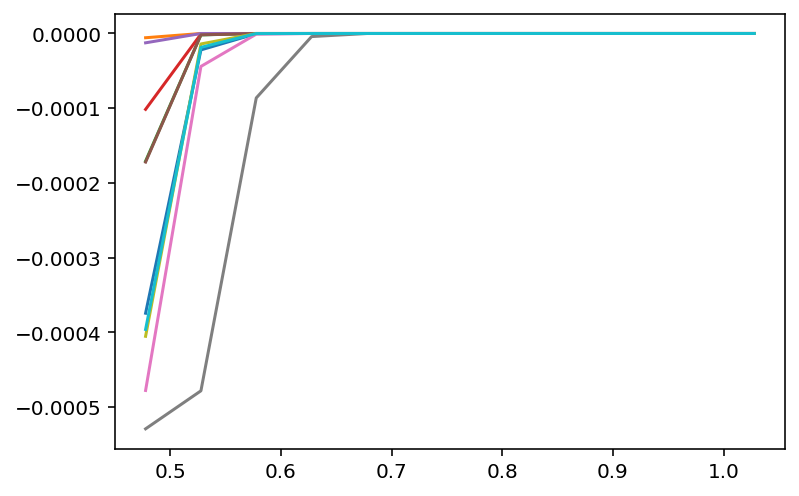

In [103]:
for ff in ff_data[1]:
    rate = ff_data[0]
    curve = []
    for f in ff:
        rate *= f
        curve.append(rate)
    plt.plot(ff_data[2][:-1], np.diff(curve))
# plt.yscale('log')

Text(0.5, 0, '$\\mathcal{O}=|x|$')

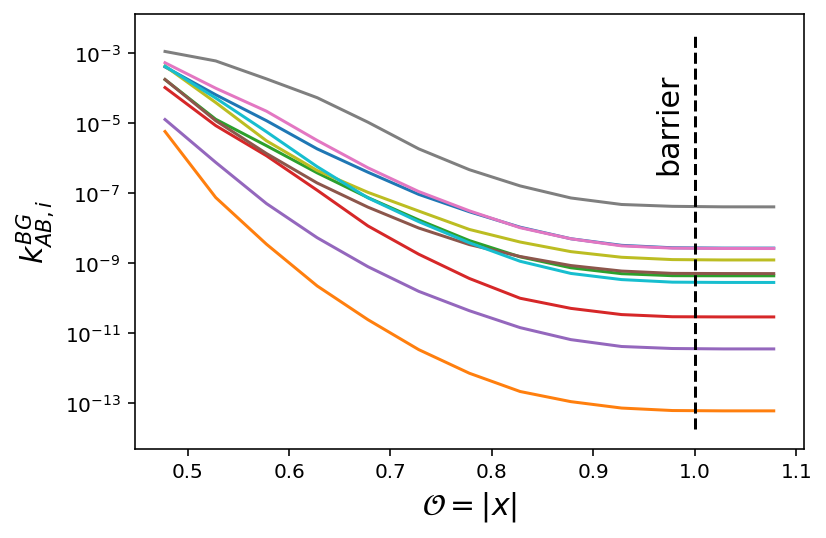

In [147]:
for ff in ff_data[1]:
    plt.plot(ff_data[2], ff_data[0]*np.array(ff))
plt.yscale('log')
plt.vlines(1.0, *plt.ylim(), "k", linestyles="--")
plt.text(0.96, 5e-7, "barrier", size=15, rotation=90)
plt.ylabel(r"$k^{BG}_{AB,i}$", size=15)
plt.xlabel(r"$\mathcal{O}=|x|$", size=15)

Text(0, 0.5, '$k^{BG}_{AB,i}$')

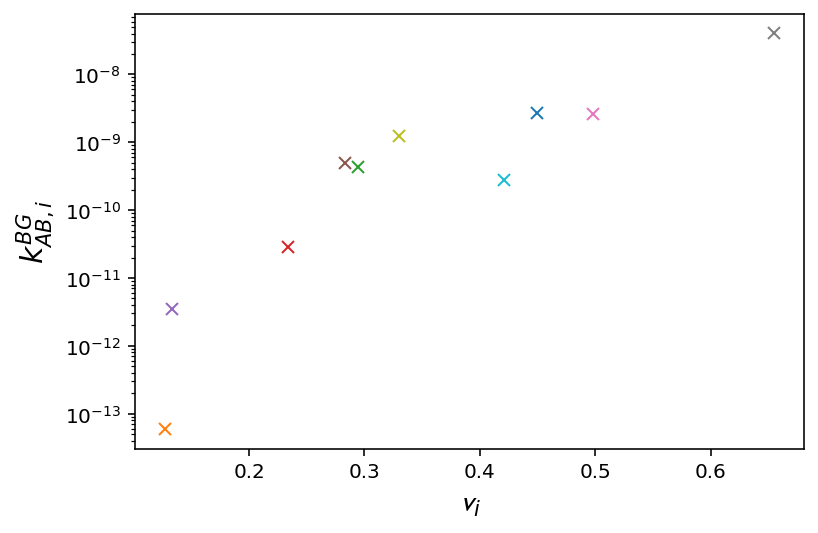

In [135]:
for i, ff in enumerate(ff_data[1]):
    plt.plot(np.abs(ff_data[3][i][1]), ff[-1]*ff_data[0], "x")
plt.yscale('log')
plt.xlabel(r"$\mathcal{v}_i$", size=15)
plt.ylabel(r"$k^{BG}_{AB,i}$", size=15)

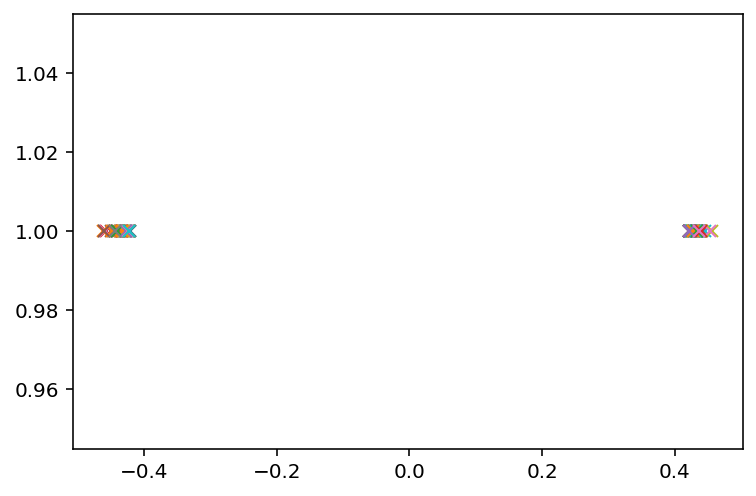

In [369]:
for ff in ff_data[3]:
    tmp = ff[0]
    plt.plot(tmp[0], np.sign(tmp[0]*tmp[1]), "x")

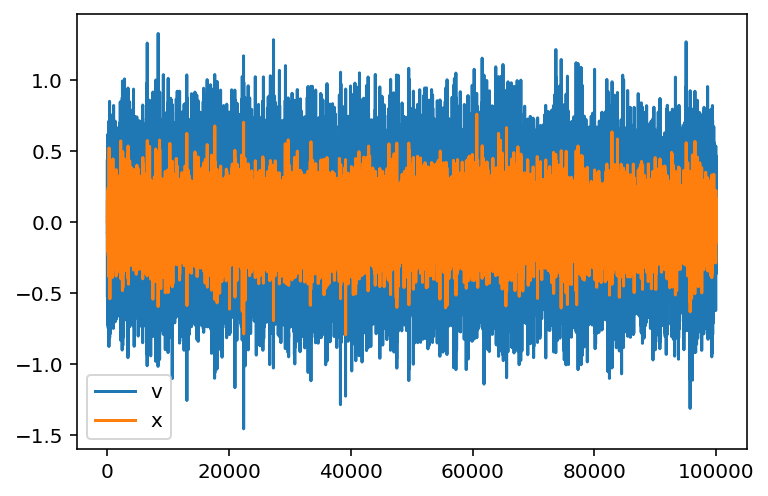

In [57]:
plt.plot(sim.out_v, label="v");
plt.plot(sim.out_x, label="x");
plt.legend()

In [52]:
sim.out_op

[]

Text(0, 0.5, '$P(x)$')

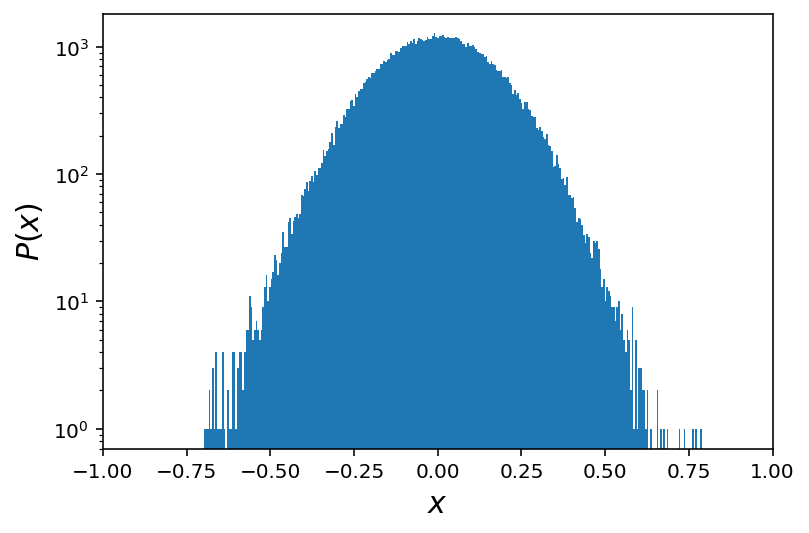

In [152]:
plt.hist(sim.out_x, bins=np.linspace(-1.0, 1.0, 400))
plt.xlim(-1.0, 1.0)
plt.yscale('log')
plt.xlabel(r"$x$", size=15)
plt.ylabel(r"$P(x)$", size=15)

Text(0, 0.5, '$P(\\mathcal{O})$')

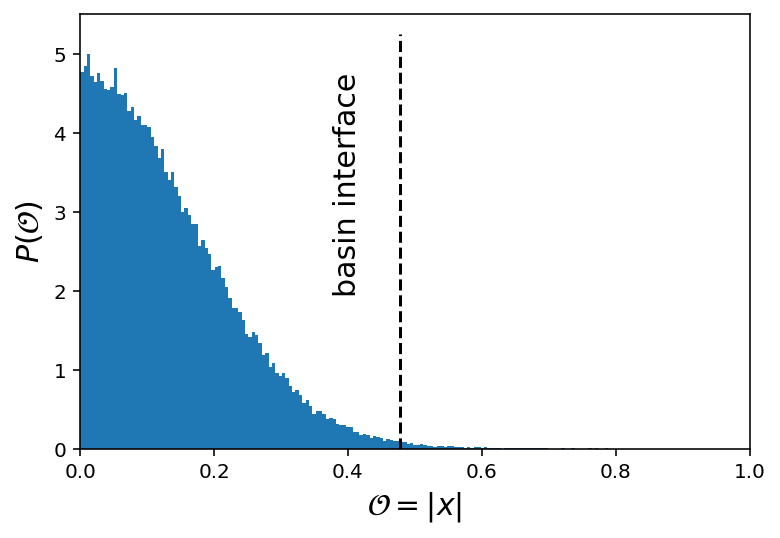

In [153]:
plt.hist(sim.out_op, bins=np.linspace(0.0, 1.0, 200), density=True)
plt.xlim(0.0, 1.0)
# plt.yscale('log')
plt.vlines(sim.basin, *plt.ylim(), "k", linestyles="--")
plt.text(sim.basin-.1, 2, "basin interface", size=15, rotation=90)
plt.xlabel(r"$\mathcal{O}=|x|$", size=15)
plt.ylabel(r"$P(\mathcal{O})$", size=15)

In [136]:
np.quantile(sim.out_op, 0.99)

0.43352255471649526

In [54]:
data = []
kTs = np.linspace(0.05, 0.4, 8)
for kT in kTs:
    sim = FFTestSim(kT, rng, op, force_0, threshold=1.0, dt=0.1)
    sim.run(100_000)
    data.append(np.max(sim.out_x))

(0.0, 1.0)

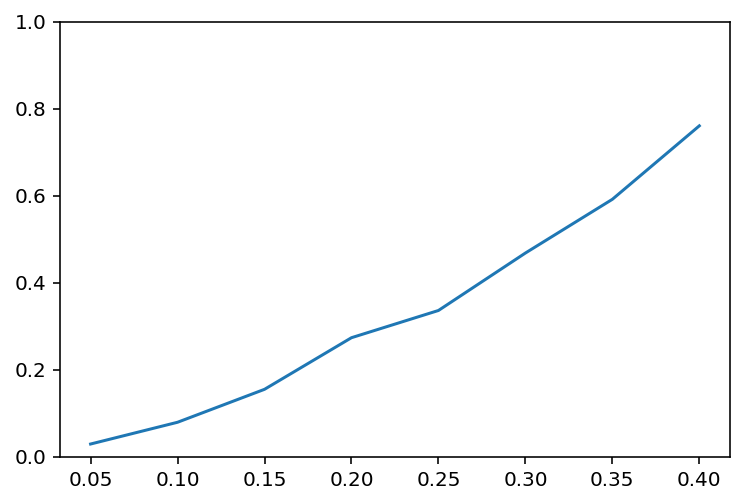

In [55]:
plt.plot(kTs, data)
# plt.yscale('log')
plt.ylim(0.0, 1.0)

### How would this work with HOOMDs API?

We want to control the simulation state: run, restart, modify state, rerun, restart, etc.
But we also want the user to have full control of setting up the simulation state prior to
initializing any FFS calculation. HOOMDs `Action` API seems to be a good fit. I'm just
not sure how well the trigger mechanism fits within it. Since we're going to have to calculate
the order parameter at every timestep (or at least every couple) we are going to have to
be working within HOOMD (we can't just wrap everything up in a big ol' python class). 

Some requirements
* The FFS algo is going to have to be able to be interrupted (effeciently) every M simulation steps
* Must be able to store and resume many simulation states to implement the BG-FFS algo
* Controlling code can just be single threaded
* Can I make this multithreaded? If so that would be nice. Have multiple simulation contexts running

I think that the best way to implement this may be through a unique `Method` class.
The method makes sense with Langevin dynamics, so let's implement that first